<a href="https://colab.research.google.com/github/Elsayedmostafa574/Cword_Counting_Model_3/blob/main/Crowd_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing_the_librabries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,cv2
from glob import glob
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import operator
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          11519        350  1.0              
zusmani/petrolgas-prices-worldwide                              Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33            793         62  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           6586        192  0.9705882        
ruchi798/data-science-job-salaries                          

In [ ]:
!kaggle datasets download -d fmena14/crowd-counting

 99% 1.17G/1.18G [00:38<00:00, 33.7MB/s]
100% 1.18G/1.18G [00:38<00:00, 33.1MB/s]


In [ ]:
! unzip crowd-counting.zip -d crowd-counting

Archive:  crowd-counting.zip
  inflating: crowd-counting/frames/frames/seq_000001.jpg  
  inflating: crowd-counting/frames/frames/seq_000002.jpg  
  inflating: crowd-counting/frames/frames/seq_000003.jpg  
  inflating: crowd-counting/frames/frames/seq_000004.jpg  
  inflating: crowd-counting/frames/frames/seq_000005.jpg  
  inflating: crowd-counting/frames/frames/seq_000006.jpg  
  inflating: crowd-counting/frames/frames/seq_000007.jpg  
  inflating: crowd-counting/frames/frames/seq_000008.jpg  
  inflating: crowd-counting/frames/frames/seq_000009.jpg  
  inflating: crowd-counting/frames/frames/seq_000010.jpg  
  inflating: crowd-counting/frames/frames/seq_000011.jpg  
  inflating: crowd-counting/frames/frames/seq_000012.jpg  
  inflating: crowd-counting/frames/frames/seq_000013.jpg  
  inflating: crowd-counting/frames/frames/seq_000014.jpg  
  inflating: crowd-counting/frames/frames/seq_000015.jpg  
  inflating: crowd-counting/frames/frames/seq_000016.jpg  
  inflating: crowd-counting

In [ ]:
df = pd.read_csv("/content/crowd-counting/labels.csv")

In [ ]:
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [ ]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


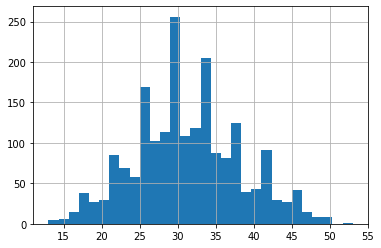

In [ ]:
df['count'].hist(bins=30);

In [ ]:
size = 224
batch_size = 64

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    vertical_flip=False,
    validation_split=0.2, 
    preprocessing_function=resnet50.preprocess_input
)

In [ ]:
flow_params = dict(
    dataframe=df,
    directory='/content/crowd-counting/frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

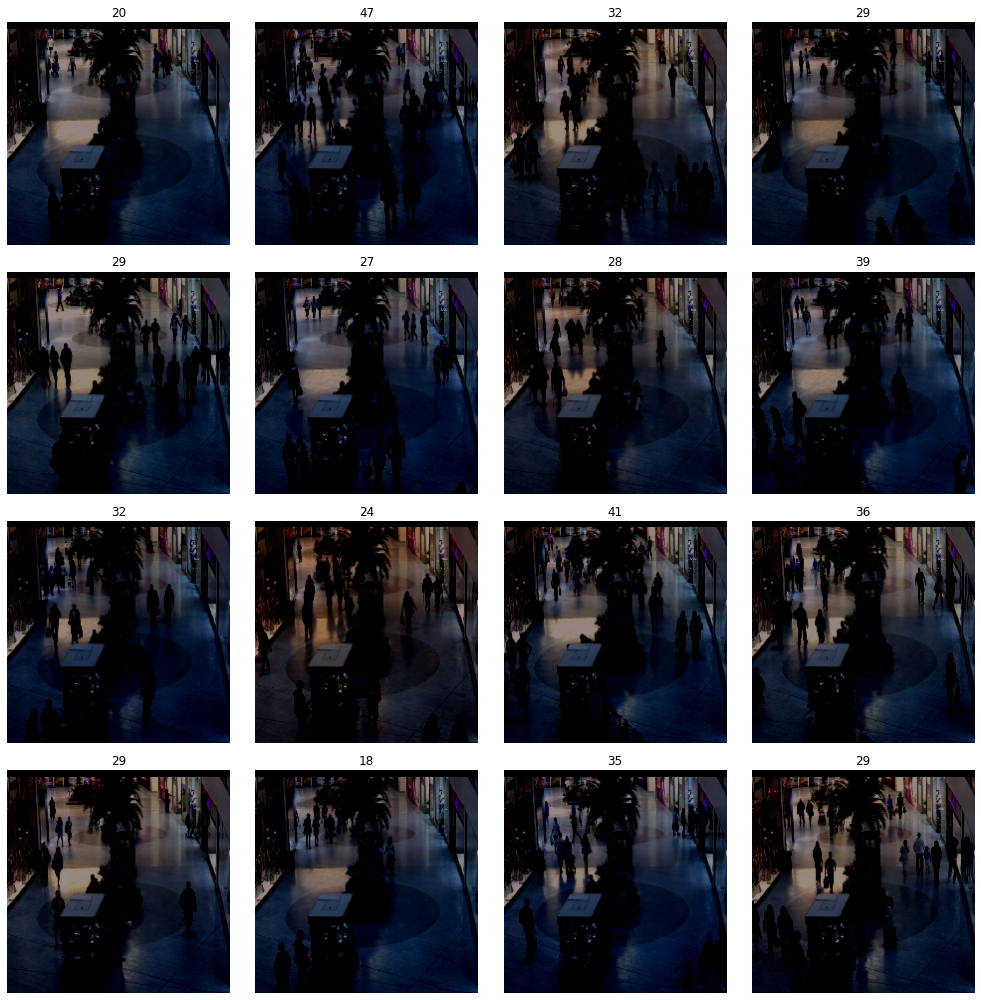

In [ ]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(size, size, 3),
    pooling='avg'
)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1, 
    factor=0.2,
    min_lr=0.000001
)

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    epochs=50,
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
25/25 - 30s - loss: 121.2770 - mean_absolute_error: 7.8649 - mean_squared_error: 121.2770 - val_loss: 2618.7236 - val_mean_absolute_error: 50.8666 - val_mean_squared_error: 2618.7236 - lr: 0.0010 - 30s/epoch - 1s/step
Epoch 2/50
25/25 - 12s - loss: 33.7383 - mean_absolute_error: 4.6514 - mean_squared_error: 33.7383 - val_loss: 1206.1583 - val_mean_absolute_error: 34.3242 - val_mean_squared_error: 1206.1583 - lr: 0.0010 - 12s/epoch - 487ms/step
Epoch 3/50
25/25 - 12s - loss: 29.4641 - mean_absolute_error: 4.3884 - mean_squared_error: 29.4641 - val_loss: 489.6865 - val_mean_absolute_error: 21.5118 - val_mean_squared_error: 489.6865 - lr: 0.0010 - 12s/epoch - 489ms/step
Epoch 4/50
25/25 - 12s - loss: 28.0945 - mean_absolute_error: 4.2310 - mean_squared_error: 28.0945 - val_loss: 246.3044 - val_mean_absolute_error: 14.8423 - val_mean_squared_error: 246.3044 - lr: 0.0010 - 12s/epoch - 491ms/step
Epoch 5/50
25/25 - 12s - loss: 26.8761 - mean_absolute_error: 4.1548 - mean_squared_e

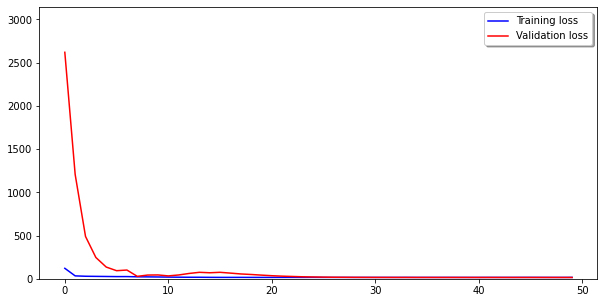

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)


In [ ]:

 print(classification_report(y_true, y_pred))
     

In [ ]:
import pickle
pickle.dump(model, open('model_corwed_detection.pkl','wb'))

INFO:tensorflow:Assets written to: ram://cc56ec61-94cc-4793-a2b4-01b43af4aa8b/assets


In [ ]:
model.save('crowd-counting.h5')

In [ ]:
pred = model.predict(valid_generator)


In [ ]:
def NewScan(imag):
    image = cv2.imread(imag,cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224,224), cv2.INTER_LINEAR)/225.0
    im = image.reshape(-1, 224, 224, 3)
    prob = model.predict(im)
    predIdx = np.argmax(prob, axis=1) 
    return predIdx
import os
import uuid
import cv2
import numpy as np
from flask import Flask, request, json, jsonify
from keras.models import load_model
app = Flask(__name__) 
#مسار المودل 
model = load_model("/content/crowd-counting.h5") 
 
@app.route('/', methods=['GET', 'POST']) 
def upload(): 
    if request.method == 'POST': 
        imgFile = request.files['img'] 
        imgFileBytes = imgFile.read() 
        imgFile.seek(0) 
        IMG_SAVED_NAME = "img_from_request.jpg" 
        imgFile.save(IMG_SAVED_NAME) 
        resultFromModel = NewScan(IMG_SAVED_NAME) 
        result = {"result":str(resultFromModel)} 
        return jsonify(data= result) 
    else: 
        return jsonify(data=None) 
 
 
if __name__ == '__main__': 
    app.run(host='0.0.0.0' , port=5001 , debug =True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5001/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
python

In [ ]:
model = keras.models.load_model('/content/crowd-counting.h5')

OSError: ignored